# CA684 Assignment: Multi-model  for Predicting Media Memorability 
### Yuwei Chen                                
### Dublin City University


In this project, I first used different single features for regression to obtain the memorability scores of the videos. In order to fuse multiple features,
My strategy is to evaluate the models using Spearman's correlation coefficient, and to select the three best models for the short-term_memorability target and the long-term_memorability target, and then to assign weights to each model according to its Spearman's correlation coefficient to form a multi-model.
I used four regressors as baseline models, namely support vector regression (SVR) and random forest regression (RFR), BayesianRidge (BR) and XGBoost model.In the end, the XGBoost model was abandoned because it performed too poorly.

In [ ]:
#import packet

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from pandas import Series,DataFrame
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
#function to get features from fname

def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

def read_LBP(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            LBP =[float(item) for item in line.split()] # convert to float type, using default separator
    return LBP

def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

def read_AES(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            LBP =[float(item) for item in line.split(",")] # convert to float type, using default separator
    return LBP

In [3]:
# load the ground truth values
labels=pd.read_csv("Dev_set//Ground-truth/ground-truth.csv")
labels

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10
...,...,...,...,...,...
5995,video7488.webm,0.921,33,1.000,9
5996,video7489.webm,0.909,53,0.839,31
5997,video7491.webm,0.713,33,0.818,11
5998,video7492.webm,0.954,34,1.000,16


In [4]:
#Extract the video number from video name
vname = labels.video
vnum = vname.map(lambda x: str(x)[5:len(x)-5])
vnum

0          3
1          4
2          6
3          8
4         10
        ... 
5995    7488
5996    7489
5997    7491
5998    7492
5999    7493
Name: video, Length: 6000, dtype: object

In [5]:
#short-term_memorability target
y_stm_target = labels["short-term_memorability"]
#long-term_memorability target
y_ltm_target = labels["long-term_memorability"]


In [6]:
# function to get features
# this function is used to get HMP,C3D and Aesthetic features
def get_features(feature_path , func):
    df = DataFrame() #data frame used to save feature
    index = 0
    for video_num in vnum :
        feature_file_name = feature_path + 'video' + video_num + '.txt' 
        data = func(feature_file_name)
        df[index] = data
        index +=1
        
    return df.T



# this function is used to get LBP features 
def get_lbp_feature(flen, feature_path , func):
    df = DataFrame() #data frame used to save feature
    index = 0  #feature index
    for video_num  in vnum :
        feature_file_name_0 = feature_path + 'video' + video_num + '-0.txt' 
        data = func(feature_file_name_0)
        #I found normal LBP feature data containing 22 features inside each file, 
        #but there were individual txt files that did not contain 122 feature values.
        #so need to make sure len(data) is 122
        data = data + [0] * (flen - len(data)) 
        feature_file_name_56 = feature_path + 'video' + video_num + '-56.txt'
        temp = func(feature_file_name_56)
        temp = temp + [0] * (flen - len(temp))
        data.extend(temp) 
        feature_file_name_112 = feature_path + 'video' + video_num + '-112.txt'
        temp = func(feature_file_name_112)
        temp = temp + [0] * (flen - len(temp))
        data.extend(temp) 
        df[index] = data
        index += 1
        
    return df.T

In [7]:
#get HMP feature from function
x_hmp_feature = get_features("Dev_set/HMP/",read_HMP)

#get LBP feature from function
x_c3d_feature = get_features("Dev_set/C3D/",read_C3D)

#get aesthetic_mean_feature
x_aes_mean = get_features("Dev_set/aesthetic_feat_dev-set_mean/",read_AES)

#get aesthetic_median_feature
x_aes_median = get_features("Dev_set/aesthetic_feat_dev-set_median//",read_AES)

#get LBP feature
#count lenth of features in per LBP feature file, i.e  LBP feature in Dev_set/LBP/video3-0.txt
lbp = read_LBP("Dev_set/LBP/video3-0.txt")
lbp_len = len(lbp)
#get LBP feature from function
x_lbp_feature = get_lbp_feature(lbp_len,"Dev_set/LBP/",read_LBP)

In [8]:
#function for Spearman's correlation coefficient
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
           
            return score_mat.iloc[1][0]
        
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])
                
            return None

Through study and investigation, the SVR, RFR and BayesianRidge models performed better on this problem. Then since the XGBoost model has a very good performance in regression, I plan to use these 4 models to test and evaluate each of my selected features to select the best combination of models.

In [19]:
#model test
#SVR models test HMP feature
svr = SVR(kernel='linear', C=1.25)
x_train,x_test,y_train,y_test = train_test_split(x_hmp_feature, y_stm_target, random_state = 44,  test_size=0.25)
svr.fit(x_train, y_train)
y_stm_predict = svr.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_hmp_feature, y_ltm_target, random_state = 44,  test_size=0.25)
svr.fit(x_train, y_train)
y_ltm_predict = svr.predict(x_test)

svr_hmp_stm = Get_score(y_stm_predict,y_test)
svr_hmp_ltm = Get_score(y_ltm_predict,y_test)

print("SVR model test HMP feature: The STM Spearman\'s correlation coefficient is %.3f" % svr_hmp_stm)
print("SVR model test HMP feature: The LTM Spearman\'s correlation coefficient is %.3f" % svr_hmp_ltm)


SVR model test HMP feature: The STM Spearman's correlation coefficient is 0.304
SVR model test HMP feature: The LTM Spearman's correlation coefficient is 0.186


In [20]:
#SVR models test C3D feature
svr = SVR(kernel='linear', C=1.25)
x_train,x_test,y_train,y_test = train_test_split(x_c3d_feature, y_stm_target, random_state = 44,  test_size=0.25)
svr.fit(x_train, y_train)
y_stm_predict = svr.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_c3d_feature, y_ltm_target, random_state = 44,  test_size=0.25)
svr.fit(x_train, y_train)
y_ltm_predict = svr.predict(x_test)

svr_c3d_stm = Get_score(y_stm_predict,y_test)
svr_c3d_ltm = Get_score(y_ltm_predict,y_test)

print("SVR model test C3D feature: The STM Spearman\'s correlation coefficient is %.3f" % svr_c3d_stm)
print("SVR model test C3D feature: The LTM Spearman\'s correlation coefficient is %.3f" % svr_c3d_ltm)


SVR model test C3D feature: The STM Spearman's correlation coefficient is 0.273
SVR model test C3D feature: The LTM Spearman's correlation coefficient is 0.191


In [21]:
#SVR models test LBP feature
svr = SVR(kernel='linear', C=1.25)
x_train,x_test,y_train,y_test = train_test_split(x_lbp_feature, y_stm_target, random_state = 44,  test_size=0.25)
svr.fit(x_train, y_train)
y_stm_predict = svr.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_lbp_feature, y_ltm_target, random_state = 44,  test_size=0.25)
svr.fit(x_train, y_train)
y_ltm_predict = svr.predict(x_test)

svr_lbp_stm = Get_score(y_stm_predict,y_test)
svr_lbp_ltm = Get_score(y_ltm_predict,y_test)

print("SVR model test LBP feature: The STM Spearman\'s correlation coefficient is %.3f" % svr_lbp_stm)
print("SVR model test LBP feature: The LTM Spearman\'s correlation coefficient is %.3f" % svr_lbp_ltm)

SVR model test LBP feature: The STM Spearman's correlation coefficient is 0.238
SVR model test LBP feature: The LTM Spearman's correlation coefficient is 0.171


In [22]:
#SVR models test aesthetic_mean_ feature
svr = SVR(kernel='linear', C=1.25)
x_train,x_test,y_train,y_test = train_test_split(x_aes_mean, y_stm_target, random_state = 44,  test_size=0.25)
transfer = StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.fit_transform(x_test)
svr.fit(x_train, y_train)
y_stm_predict = svr.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_aes_mean, y_ltm_target, random_state = 44,  test_size=0.25)
transfer = StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.fit_transform(x_test)
svr.fit(x_train, y_train)
y_ltm_predict = svr.predict(x_test)

svr_eas_stm = Get_score(y_stm_predict,y_test)
svr_eas_ltm = Get_score(y_ltm_predict,y_test)

print("SVR model test EAS feature: The STM Spearman\'s correlation coefficient is %.3f" % svr_eas_stm)
print("SVR model test EAS feature: The LTM Spearman\'s correlation coefficient is %.3f" % svr_eas_ltm)

SVR model test EAS feature: The STM Spearman's correlation coefficient is 0.221
SVR model test EAS feature: The LTM Spearman's correlation coefficient is 0.122


In [23]:
#RFR models test HMP feature
rfr = RandomForestRegressor(n_jobs=7)
x_train,x_test,y_train,y_test = train_test_split(x_hmp_feature, y_stm_target, random_state = 44,  test_size=0.25)
rfr.fit(x_train, y_train)
y_stm_predict = rfr.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_hmp_feature, y_ltm_target, random_state = 44,  test_size=0.25)
rfr.fit(x_train, y_train)
y_ltm_predict = rfr.predict(x_test)

rfr_hmp_stm = Get_score(y_stm_predict,y_test)
rfr_hmp_ltm = Get_score(y_ltm_predict,y_test)

print("RFR model test HMP feature: The STM Spearman\'s correlation coefficient is %.3f" % rfr_hmp_stm)
print("RFR model test HMP feature: The LTM Spearman\'s correlation coefficient is %.3f" % rfr_hmp_ltm)


RFR model test HMP feature: The STM Spearman's correlation coefficient is 0.247
RFR model test HMP feature: The LTM Spearman's correlation coefficient is 0.190


In [24]:
#RFR models test C3D feature
rfr = RandomForestRegressor(n_jobs=7)
x_train,x_test,y_train,y_test = train_test_split(x_c3d_feature, y_stm_target, random_state = 44,  test_size=0.25)
rfr.fit(x_train, y_train)
y_stm_predict = rfr.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_c3d_feature, y_ltm_target, random_state = 44,  test_size=0.25)
rfr.fit(x_train, y_train)
y_ltm_predict = rfr.predict(x_test)

rfr_c3d_stm = Get_score(y_stm_predict,y_test)
rfr_c3d_ltm = Get_score(y_ltm_predict,y_test)

print("RFR model test C3D feature: The STM Spearman\'s correlation coefficient is %.3f" % rfr_c3d_stm)
print("RFR model test C3D feature: The LTM Spearman\'s correlation coefficient is %.3f" % rfr_c3d_ltm)


RFR model test C3D feature: The STM Spearman's correlation coefficient is 0.374
RFR model test C3D feature: The LTM Spearman's correlation coefficient is 0.165


In [25]:
#RFR models test LBP feature
rfr = RandomForestRegressor(n_jobs=7)
x_train,x_test,y_train,y_test = train_test_split(x_lbp_feature, y_stm_target, random_state = 44,  test_size=0.25)
rfr.fit(x_train, y_train)
y_stm_predict = rfr.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_lbp_feature, y_ltm_target, random_state = 44,  test_size=0.25)
rfr.fit(x_train, y_train)
y_ltm_predict = rfr.predict(x_test)

rfr_lbp_stm = Get_score(y_stm_predict,y_test)
rfr_lbp_ltm = Get_score(y_ltm_predict,y_test)

print("RFR model test LBP feature: The STM Spearman\'s correlation coefficient is %.3f" % rfr_lbp_stm)
print("RFR model test LBP feature: The LTM Spearman\'s correlation coefficient is %.3f" % rfr_lbp_ltm)

RFR model test LBP feature: The STM Spearman's correlation coefficient is 0.225
RFR model test LBP feature: The LTM Spearman's correlation coefficient is 0.203


In [26]:
#RFR models test aesthetic_mean_ feature
rfr = RandomForestRegressor(n_jobs=7)
x_train,x_test,y_train,y_test = train_test_split(x_aes_mean, y_stm_target, random_state = 44,  test_size=0.25)
transfer = StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.fit_transform(x_test)
rfr.fit(x_train, y_train)
y_stm_predict = rfr.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_aes_mean, y_ltm_target, random_state = 44,  test_size=0.25)
transfer = StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.fit_transform(x_test)
rfr.fit(x_train, y_train)
y_ltm_predict = rfr.predict(x_test)

rfr_eas_stm = Get_score(y_stm_predict,y_test)
rfr_eas_ltm = Get_score(y_ltm_predict,y_test)

print("RFR model test EAS feature: The STM Spearman\'s correlation coefficient is %.3f" % rfr_eas_stm)
print("RFR model test EAS feature: The LTM Spearman\'s correlation coefficient is %.3f" % rfr_eas_ltm)

RFR model test EAS feature: The STM Spearman's correlation coefficient is 0.276
RFR model test EAS feature: The LTM Spearman's correlation coefficient is 0.196


In [27]:
#BayesianRidge models test HMP feature
br = BayesianRidge()
x_train,x_test,y_train,y_test = train_test_split(x_hmp_feature, y_stm_target, random_state = 44,  test_size=0.25)
br.fit(x_train, y_train)
y_stm_predict = br.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_hmp_feature, y_ltm_target, random_state = 44,  test_size=0.25)
br.fit(x_train, y_train)
y_ltm_predict = br.predict(x_test)

br_hmp_stm = Get_score(y_stm_predict,y_test)
br_hmp_ltm = Get_score(y_ltm_predict,y_test)

print("BR model test HMP feature: The STM Spearman\'s correlation coefficient is %.3f" % br_hmp_stm)
print("BR model test HMP feature: The LTM Spearman\'s correlation coefficient is %.3f" % br_hmp_ltm)

BR model test HMP feature: The STM Spearman's correlation coefficient is 0.254
BR model test HMP feature: The LTM Spearman's correlation coefficient is 0.191


In [28]:
#BayesianRidge models test C3D feature
br = BayesianRidge( )
x_train,x_test,y_train,y_test = train_test_split(x_c3d_feature, y_stm_target, random_state = 44,  test_size=0.25)
br.fit(x_train, y_train)
y_stm_predict = br.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_c3d_feature, y_ltm_target, random_state = 44,  test_size=0.25)
br.fit(x_train, y_train)
y_ltm_predict = br.predict(x_test)

br_c3d_stm = Get_score(y_stm_predict,y_test)
br_c3d_ltm = Get_score(y_ltm_predict,y_test)

print("BR model test C3D feature: The STM Spearman\'s correlation coefficient is %.3f" % br_c3d_stm)
print("BR model test C3D feature: The LTM Spearman\'s correlation coefficient is %.3f" % br_c3d_ltm)


BR model test C3D feature: The STM Spearman's correlation coefficient is 0.228
BR model test C3D feature: The LTM Spearman's correlation coefficient is 0.189


In [29]:
#BayesianRidge models test LBP feature
br = BayesianRidge()
x_train,x_test,y_train,y_test = train_test_split(x_lbp_feature, y_stm_target, random_state = 44,  test_size=0.25)
br.fit(x_train, y_train)
y_stm_predict = br.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_lbp_feature, y_ltm_target, random_state = 44,  test_size=0.25)
br.fit(x_train, y_train)
y_ltm_predict = br.predict(x_test)

br_lbp_stm = Get_score(y_stm_predict,y_test)
br_lbp_ltm = Get_score(y_ltm_predict,y_test)

print("BR model test LBP feature: The STM Spearman\'s correlation coefficient is %.3f" % br_lbp_stm)
print("BR model test LBP feature: The LTM Spearman\'s correlation coefficient is %.3f" % br_lbp_ltm)

BR model test LBP feature: The STM Spearman's correlation coefficient is 0.184
BR model test LBP feature: The LTM Spearman's correlation coefficient is 0.146


In [30]:
#BayesianRidge models test aesthetic_mean_ feature
br = BayesianRidge()
x_train,x_test,y_train,y_test = train_test_split(x_aes_mean, y_stm_target, random_state = 44,  test_size=0.25)
transfer = StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.fit_transform(x_test)
br.fit(x_train, y_train)
y_stm_predict = br.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_aes_mean, y_ltm_target, random_state = 44,  test_size=0.25)
transfer = StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.fit_transform(x_test)
br.fit(x_train, y_train)
y_ltm_predict = br.predict(x_test)

br_eas_stm = Get_score(y_stm_predict,y_test)
br_eas_ltm = Get_score(y_ltm_predict,y_test)

print("BR model test EAS feature: The STM Spearman\'s correlation coefficient is %.3f" % br_eas_stm)
print("BR model test EAS feature: The LTM Spearman\'s correlation coefficient is %.3f" % br_eas_ltm)

BR model test EAS feature: The STM Spearman's correlation coefficient is 0.195
BR model test EAS feature: The LTM Spearman's correlation coefficient is 0.183


In [31]:
#XGBoost models test HMP feature
xgboost = XGBClassifier(n_jobs = 7)
x_train,x_test,y_train,y_test = train_test_split(x_hmp_feature, y_stm_target, random_state = 44,  test_size=0.25)
xgboost.fit(x_train, y_train)
y_stm_predict = xgboost.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_hmp_feature, y_ltm_target, random_state = 44,  test_size=0.25)
xgboost.fit(x_train, y_train)
y_ltm_predict = xgboost.predict(x_test)

xgboost_hmp_stm = Get_score(y_stm_predict,y_test)
xgboost_hmp_ltm = Get_score(y_ltm_predict,y_test)

print("xgboost model test HMP feature: The STM Spearman\'s correlation coefficient is %.3f" % xgboost_hmp_stm)
print("xgboost model test HMP feature: The LTM Spearman\'s correlation coefficient is %.3f" % xgboost_hmp_ltm)

xgboost model test HMP feature: The STM Spearman's correlation coefficient is 0.088
xgboost model test HMP feature: The LTM Spearman's correlation coefficient is 0.033


In [32]:
#XGBoost  models test C3D feature
xgboost = XGBClassifier(n_jobs = 7)
x_train,x_test,y_train,y_test = train_test_split(x_c3d_feature, y_stm_target, random_state = 44,  test_size=0.25)
xgboost.fit(x_train, y_train)
y_stm_predict = xgboost.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_c3d_feature, y_ltm_target, random_state = 44,  test_size=0.25)
xgboost.fit(x_train, y_train)
y_ltm_predict = xgboost.predict(x_test)

xgboost_c3d_stm = Get_score(y_stm_predict,y_test)
xgboost_c3d_ltm = Get_score(y_ltm_predict,y_test)

print("xgboost model test C3D feature: The STM Spearman\'s correlation coefficient is %.3f" % xgboost_c3d_stm)
print("xgboost model test C3D feature: The LTM Spearman\'s correlation coefficient is %.3f" % xgboost_c3d_ltm)


xgboost model test C3D feature: The STM Spearman's correlation coefficient is 0.110
xgboost model test C3D feature: The LTM Spearman's correlation coefficient is 0.080


In [33]:
#XGBoost models test LBP feature
xgboost = XGBClassifier(n_jobs = 7)
x_train,x_test,y_train,y_test = train_test_split(x_lbp_feature, y_stm_target, random_state = 44,  test_size=0.25)
xgboost.fit(x_train, y_train)
y_stm_predict = xgboost.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_lbp_feature, y_ltm_target, random_state = 44,  test_size=0.25)
xgboost.fit(x_train, y_train)
y_ltm_predict = xgboost.predict(x_test)

xgboost_lbp_stm = Get_score(y_stm_predict,y_test)
xgboost_lbp_ltm = Get_score(y_ltm_predict,y_test)

print("xgboost model test LBP feature: The STM Spearman\'s correlation coefficient is %.3f" % xgboost_lbp_stm)
print("xgboost model test LBP feature: The LTM Spearman\'s correlation coefficient is %.3f" % xgboost_lbp_ltm)

xgboost model test LBP feature: The STM Spearman's correlation coefficient is 0.098
xgboost model test LBP feature: The LTM Spearman's correlation coefficient is 0.010


In [34]:
#XGBoost models test aesthetic_mean_ feature
xgboost = XGBClassifier(n_jobs = 7)
x_train,x_test,y_train,y_test = train_test_split(x_aes_mean, y_stm_target, random_state = 44,  test_size=0.25)
transfer = StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.fit_transform(x_test)
xgboost.fit(x_train, y_train)
y_stm_predict = xgboost.predict(x_test)

x_train,x_test,y_train,y_test = train_test_split(x_aes_mean, y_ltm_target, random_state = 44,  test_size=0.25)
transfer = StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.fit_transform(x_test)
xgboost.fit(x_train, y_train)
y_ltm_predict =xgboost.predict(x_test)

xgboost_eas_stm = Get_score(y_stm_predict,y_test)
xgboost_eas_ltm = Get_score(y_ltm_predict,y_test)

print("xgboost model test EAS feature: The STM Spearman\'s correlation coefficient is %.3f" % xgboost_eas_stm)
print("xgboost model test EAS feature: The LTM Spearman\'s correlation coefficient is %.3f" % xgboost_eas_ltm)

xgboost model test EAS feature: The STM Spearman's correlation coefficient is 0.130
xgboost model test EAS feature: The LTM Spearman's correlation coefficient is 0.030


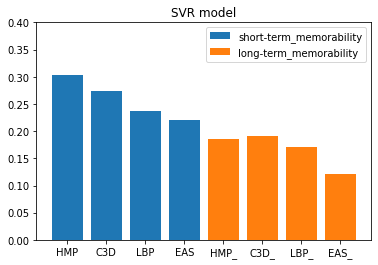

In [16]:
#Histogram to see how each model behaves on each feature
#SVR model
plt.bar(["HMP","C3D","LBP","EAS"],[svr_hmp_stm,svr_c3d_stm,svr_lbp_stm,svr_eas_stm],label='short-term_memorability')
plt.bar(["HMP_","C3D_","LBP_","EAS_"],[svr_hmp_ltm,svr_c3d_ltm,svr_lbp_ltm,svr_eas_ltm],label='long-term_memorability')
plt.title('SVR model')
plt.ylim(0,0.4)
plt.legend()
plt.show()

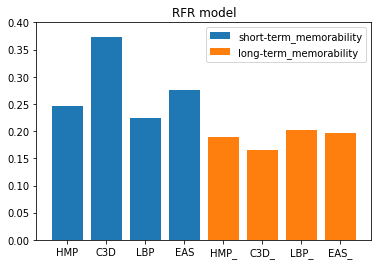

In [17]:
#RFR  model
plt.bar(["HMP","C3D","LBP","EAS"],[rfr_hmp_stm,rfr_c3d_stm,rfr_lbp_stm,rfr_eas_stm],label='short-term_memorability')
plt.bar(["HMP_","C3D_","LBP_","EAS_"],[rfr_hmp_ltm,rfr_c3d_ltm,rfr_lbp_ltm,rfr_eas_ltm],label='long-term_memorability')
plt.title('RFR model')
plt.ylim(0,0.4)
plt.legend()
plt.show()

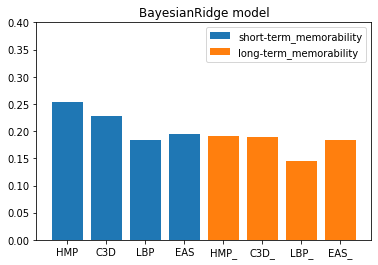

In [18]:
#BayesianRidge model
plt.bar(["HMP","C3D","LBP","EAS"],[br_hmp_stm,br_c3d_stm,br_lbp_stm,br_eas_stm],label='short-term_memorability')
plt.bar(["HMP_","C3D_","LBP_","EAS_"],[br_hmp_ltm,br_c3d_ltm,br_lbp_ltm,br_eas_ltm],label='long-term_memorability')
plt.title('BayesianRidge model')
plt.ylim(0,0.4)
plt.legend()
plt.show()

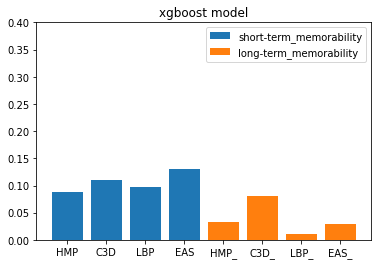

In [13]:
#xgboost model
plt.bar(["HMP","C3D","LBP","EAS"],[xgboost_hmp_stm,xgboost_c3d_stm,xgboost_lbp_stm,xgboost_eas_stm],label='short-term_memorability')
plt.bar(["HMP_","C3D_","LBP_","EAS_"],[xgboost_hmp_ltm,xgboost_c3d_ltm,xgboost_lbp_ltm,xgboost_eas_ltm],label='long-term_memorability')
plt.title('xgboost model')
plt.ylim(0,0.4)
plt.legend()
plt.show()

In [56]:
#All the models performed better except the XGboost model, which I gave up using and now I don't think it applies to this problem.
#for short-term_memorability target, I choose SVR_HMP(SVR model, HMP feature as input) ,RFR_LBP and BR_EAS
#for long-term_memorability target, I choose SVR_C3D,RFR_EAS and BR_HMP

#Set model weights for short-term_memorability target
w_total = svr_hmp_stm + rfr_c3d_stm + rfr_eas_stm
sh = svr_hmp_stm/w_total
rc = rfr_c3d_stm/w_total
re = rfr_eas_stm/w_total

#Set model weights for short-term_memorability target
w_total = svr_c3d_ltm + rfr_eas_ltm + br_hmp_ltm
sc = svr_c3d_ltm/w_total
re = rfr_eas_ltm/w_total
bh = br_hmp_ltm/w_total


In [58]:
# load the ground truth values temp
labels_tem=pd.read_csv("Test_set/Ground-truth_test/ground_truth_template.csv")
labels_tem

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10
...,...,...,...,...,...
1995,10004,NaN,34,NaN,17
1996,10005,NaN,34,NaN,9
1997,10006,NaN,34,NaN,12
1998,10007,NaN,34,NaN,12


In [64]:
#since I need to get the test feature data, 
#so we need to re-get the video num so that I can get features by dunctions
#get video num
vname = labels_tem.video
vnum = vname.map(lambda x: str(x))

In [ ]:
#load prediction features
hmp_feature = get_features("Test_set/HMP_test/",read_HMP)
eas_feature = get_features("Test_set/aesthetic_vis_features_test/mean/",read_AES)
c3d_feature = get_features("Test_set/C3D_test/",read_C3D)
lbp_feature = get_lbp_feature(lbp_len,"Test_set/LBP_test/",read_LBP)

In [ ]:
#SVR_HMP model for short-term_memorability target
svr = SVR(kernel='linear', C=1.25)
svr.fit(x_hmp_feature, y_stm_target)
stm_sh_predict = svr.predict(hmp_feature)


In [ ]:
#RFR_C3D model for short-term_memorability target
rfr = RandomForestRegressor(n_jobs=7)
rfr.fit(x_c3d_feature, y_stm_target)
stm_rc_predict = rfr.predict(c3d_feature)

In [ ]:
#RFR_EAS model for short-term_memorability target
rfr = RandomForestRegressor(n_jobs=7)
rfr.fit(x_eas_feature, y_stm_target)
stm_re_predict = rfr.predict(eas_feature)

In [ ]:
#SVR_C3D model for long-term_memorability target
svr = SVR(kernel='linear', C=1.25)
svr.fit(x_c3d_feature, y_ltm_target)
ltm_sc_predict = svr.predict(c3d_feature)

In [ ]:
#RFR_EAS  model for long-term_memorability target
rfr = RandomForestRegressor(n_jobs=7)
rfr.fit(x_eas_feature, y_ltm_target)
ltm_re_predict = rfr.predict(eas_feature)

In [ ]:
#BR_HMP model for long-term_memorability target
br = BayesianRidge()
br.fit(x_hmp_feature, y_ltm_target)
ltm_bh_predict = br.predict(hmp_feature)

In [80]:
#get a Multi-modal to get final target prediction
#the final short-term_memorability prediction
stm_predict = (sh * stm_sh_predict) + (rc * stm_rc_predict) + (re * stm_re_predict) 
stm_predict

array([0.86480475, 0.82630114, 0.86865676, ..., 0.87424482, 0.82687009,
       0.89980873])

In [81]:
#the final long-term_memorability prediction
ltm_predict = (sc * ltm_sc_predict) + (re * ltm_re_predict) + (bh * ltm_bh_predict)
ltm_predict

array([0.80484214, 0.75700107, 0.807141  , ..., 0.81572903, 0.77873349,
       0.83791676])

In [82]:
#get a final DataFrame
ground_truth_prediction = DataFrame(vname)
ground_truth_prediction["short-term_memorability"] = stm_predic
ground_truth_prediction["nb_short-term_annotations"] = labels_tem["nb_short-term_annotations"]
ground_truth_prediction["long-term_memorability"] = ltm_predict
ground_truth_prediction["nb_long-term_annotations"] = labels_tem["nb_long-term_annotations"]
ground_truth_prediction

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.864805,33,0.804842,12
1,7495,0.826301,34,0.757001,10
2,7496,0.868657,32,0.807141,13
3,7497,0.861414,33,0.758540,10
4,7498,0.872343,33,0.807968,10
...,...,...,...,...,...
1995,10004,0.852893,34,0.796260,17
1996,10005,0.865800,34,0.802041,9
1997,10006,0.874245,34,0.815729,12
1998,10007,0.826870,34,0.778733,12


In [68]:
#generate the csv file
ground_truth_prediction.to_csv("Yuwei_Chen_20213814_predictions.csv")